In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import copy

In [ ]:
# init Environment
# env = gym.make("CartPole-v0")
env = gym.make("CartPole-v1")
action_space = env.action_space.n
state_space = env.observation_space.shape[0]
hidden_size = 64
seed = 1

# max_reward = 200 # v0
max_reward = 475  # v1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# How these scales are determined? Hyperparameters?
horizon_scale = 0.02
return_scale = 0.02

replay_size = 700
n_warm_up_episodes = 50
n_updates_per_iter = 100
n_episodes_per_iter = 15
last_few = 50
batch_size = 256

2


## Behavior Function

In [ ]:
class BF(nn.Module):
    def __init__(self, state_space, action_space, hidden_size, seed):
        super(BF, self).__init__()
        torch.manual_seed(seed)
        self.actions = np.arange(action_space)
        self.action_space = action_space
        self.fc1 = nn.Linear(state_space, hidden_size)

        # Commands consists of: (desired reward, desired horizon)
        self.commands = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, action_space)
        self.sigmoid = nn.Sigmoid()

    def forward(self, state, command):

        out = self.sigmoid(self.fc1(state))
        command_out = self.sigmoid(self.commands(command))
        out = out * command_out
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = self.fc5(out)

        return out

    def action(self, state, desire, horizon):
        """
        Samples the action based on their probability
        """
        command = torch.cat((desire * return_scale, horizon * horizon_scale), dim=-1)
        action_prob = self.forward(state, command)
        probs = torch.softmax(action_prob, dim=-1)
        m = Categorical(probs)
        action = m.sample()
        return action

    def greedy_action(self, state, desire, horizon):
        """
        Returns the greedy action
        """
        command = torch.cat((desire * return_scale, horizon * horizon_scale), dim=-1)
        action_prob = self.forward(state, command)
        probs = torch.softmax(action_prob, dim=-1)
        action = torch.argmax(probs).item()
        return action

## Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []

    def add_sample(self, states, actions, rewards):
        episode = {
            "states": states,
            "actions": actions,
            "rewards": rewards,
            "summed_rewards": sum(rewards),
        }
        self.buffer.append(episode)

    def sort(self):
        # sort buffer
        self.buffer = sorted(
            self.buffer, key=lambda i: i["summed_rewards"], reverse=True
        )
        # keep the max buffer size
        self.buffer = self.buffer[: self.max_size]

    def get_random_samples(self, batch_size):
        self.sort()
        idxs = np.random.randint(0, len(self.buffer), batch_size)
        batch = [self.buffer[idx] for idx in idxs]
        return batch

    def get_nbest(self, n):
        self.sort()
        return self.buffer[:n]

    def __len__(self):
        return len(self.buffer)

### init replay buffer with n-warmup runs 

In [ ]:
buffer = ReplayBuffer(replay_size)
bf = BF(state_space, action_space, hidden_size, seed).to(device)
optimizer = optim.Adam(params=bf.parameters(), lr=1e-3)

samples = []
# initial command
init_desired_reward = 1
init_time_horizon = 1

for i in range(n_warm_up_episodes):
    desired_return = torch.FloatTensor([init_desired_reward])
    desired_time_horizon = torch.FloatTensor([init_time_horizon])
    state = env.reset()[0]
    states = []
    actions = []
    rewards = []
    while True:
        action = bf.action(
            torch.from_numpy(state).float().to(device),
            desired_return.to(device),
            desired_time_horizon.to(device),
        )
        # print(env.step(action.cpu().numpy()))
        next_state, reward, done, _, _ = env.step(action.cpu().numpy())
        # next_state, reward, done, _ = env.step(action.cpu().numpy())
        states.append(torch.from_numpy(state).float())
        actions.append(action)
        rewards.append(reward)

        state = next_state
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor(
            [np.maximum(desired_time_horizon, 1).item()]
        )

        if done:
            break

    buffer.add_sample(states, actions, rewards)

In [ ]:
# OBSERVE THE WEIGHTS before training
# for p in bf.parameters():
    # print(p)

In [ ]:
# FUNCTIONS FOR Sampling exploration commands
def sampling_exploration(top_X_eps=last_few):
    """
    This function calculates the new desired reward and new desired horizon based on the replay buffer.
    New desired horizon is calculted by the mean length of the best last X episodes.
    New desired reward is sampled from a uniform distribution given the mean and the std calculated from the last best X performances.
    where X is the hyperparameter last_few.

    """

    top_X = buffer.get_nbest(top_X_eps)
    # The exploratory desired horizon dh0 is set to the mean of the lengths of the selected episodes
    new_desired_horizon = np.mean([len(i["states"]) for i in top_X])
    # save all top_X cumulative returns in a list
    returns = [i["summed_rewards"] for i in top_X]
    # from these returns calc the mean and std
    mean_returns = np.mean(returns)
    std_returns = np.std(returns)
    # sample desired reward from a uniform distribution given the mean and the std
    new_desired_reward = np.random.uniform(mean_returns, mean_returns + std_returns)

    return torch.FloatTensor([new_desired_reward]), torch.FloatTensor(
        [new_desired_horizon]
    )

In [ ]:
# FUNCTIONS FOR TRAINING
def select_time_steps(saved_episode):
    """
    Given a saved episode from the replay buffer this function samples random time steps (t1 and t2) in that episode:
    T = max time horizon in that episode
    Returns t1, t2 and T

    t1 < t2 is guaranteed    
    """
    # Select times in the episode:
    T = len(saved_episode["states"])  # episode max horizon
    t1 = np.random.randint(0, T - 1)
    t2 = np.random.randint(t1 + 1, T)

    return t1, t2, T


def create_training_input(episode, t1, t2):
    """
    Based on the selected episode and the given time steps this function returns 4 values:
    1. state at t1
    2. the desired reward: sum over all rewards from t1 to t2
    3. the time horizont: t2 - t1

    4. the target action taken at t1

    buffer episodes are build like [cumulative episode reward, states, actions, rewards]
    """
    state = episode["states"][t1]
    desired_reward = sum(episode["rewards"][t1:t2])
    time_horizont = t2 - t1
    action = episode["actions"][t1]
    return state, desired_reward, time_horizont, action


def create_training_examples(batch_size):
    """
    Creates a data set of training examples that can be used to create a data loader for training.
    ============================================================
    1. for the given batch_size episode idx are randomly selected
    2. based on these episodes t1 and t2 are samples for each selected episode
    3. for the selected episode and sampled t1 and t2 trainings values are gathered
    ______________________________________________________________
    Output are two numpy arrays in the length of batch size:
    Input Array for the Behavior function - consisting of (state, desired_reward, time_horizon)
    Output Array with the taken actions
    """
    input_array = []
    output_array = []
    # select randomly episodes from the buffer
    episodes = buffer.get_random_samples(batch_size)
    for ep in episodes:
        # select time stamps
        t1, t2, T = select_time_steps(ep)
        # For episodic tasks they set t2 to T:
        t2 = T
        state, desired_reward, time_horizont, action = create_training_input(ep, t1, t2)
        input_array.append(
            torch.cat(
                [
                    state,
                    torch.FloatTensor([desired_reward]),
                    torch.FloatTensor([time_horizont]),
                ]
            )
        )
        output_array.append(action)
    return input_array, output_array


def train_behavior_function(batch_size):
    """
    Trains the BF with on a cross entropy loss were the inputs are the action probabilities based on the state and command.
    The targets are the actions appropriate to the states from the replay buffer.
    """
    X, y = create_training_examples(batch_size)

    X = torch.stack(X)
    state = X[:, 0:state_space]
    d = X[:, state_space : state_space + 1]
    h = X[:, state_space + 1 : state_space + 2]
    command = torch.cat((d * return_scale, h * horizon_scale), dim=-1)
    y = torch.stack(y).long()
    y_ = bf(state.to(device), command.to(device)).float()
    optimizer.zero_grad()
    pred_loss = F.cross_entropy(y_, y)
    pred_loss.backward()
    optimizer.step()
    return pred_loss.detach().cpu().numpy()

In [ ]:
def evaluate(
    desired_return=torch.FloatTensor([init_desired_reward]),
    desired_time_horizon=torch.FloatTensor([init_time_horizon]),
):
    """
    Runs one episode of the environment to evaluate the bf.
    """
    state = env.reset()[0]
    rewards = 0
    while True:
        state = torch.FloatTensor(state)
        action = bf.action(
            state.to(device), desired_return.to(device), desired_time_horizon.to(device)
        )
        # state, reward, done, _ = env.step(action.cpu().numpy())
        state, reward, done, _, _ = env.step(action.cpu().numpy())
        rewards += reward
        desired_return = min(desired_return - reward, torch.FloatTensor([max_reward]))
        desired_time_horizon = max(desired_time_horizon - 1, torch.FloatTensor([1]))

        if done:
            break
    return rewards

## Training Loop

In [ ]:
# Algorithm 2 - Generates an Episode unsing the Behavior Function:
def generate_episode(
    desired_return=torch.FloatTensor([init_desired_reward]),
    desired_time_horizon=torch.FloatTensor([init_time_horizon]),
):
    """
    Generates more samples for the replay buffer.
    """
    state = env.reset()[0]
    states = []
    actions = []
    rewards = []
    while True:
        state = torch.FloatTensor(state)

        action = bf.action(
            state.to(device), desired_return.to(device), desired_time_horizon.to(device)
        )
        # next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state, reward, done, _, _ = env.step(action.cpu().numpy())
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor(
            [np.maximum(desired_time_horizon, 1).item()]
        )

        if done:
            break
    return [states, actions, rewards]


# Algorithm 1 - Upside - Down Reinforcement Learning
def run_upside_down(max_episodes):
    """ """
    all_rewards = []
    losses = []
    # The moving average of the latest 100 rewards. 
    # If less than 100 episodes are finished, then just use what we've got.
    average_100_reward = [] 
    desired_rewards_history = []
    horizon_history = []
    for ep in range(1, max_episodes + 1):

        # improve|optimize bf based on replay buffer
        loss_buffer = []
        for i in range(n_updates_per_iter):
            bf_loss = train_behavior_function(batch_size)
            loss_buffer.append(bf_loss)
        bf_loss = np.mean(loss_buffer)
        losses.append(bf_loss)

        # run x new episode and add to buffer
        for i in range(n_episodes_per_iter):

            # Sample exploratory commands based on buffer
            new_desired_reward, new_desired_horizon = sampling_exploration()
            generated_episode = generate_episode(
                new_desired_reward, new_desired_horizon
            )
            buffer.add_sample(
                generated_episode[0], generated_episode[1], generated_episode[2]
            )

        new_desired_reward, new_desired_horizon = sampling_exploration()
        # monitoring desired reward and desired horizon
        desired_rewards_history.append(new_desired_reward.item())
        horizon_history.append(new_desired_horizon.item())

        ep_rewards = evaluate(new_desired_reward, new_desired_horizon)
        all_rewards.append(ep_rewards)
        average_100_reward.append(np.mean(all_rewards[-100:]))

        print(
            "\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(
                ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss
            ),
            end="",
            flush=True,
        )
        if ep % 100 == 0:
            print(
                "\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(
                    ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss
                )
            )

    return (
        all_rewards,
        average_100_reward,
        desired_rewards_history,
        horizon_history,
        losses,
    )

Episode: 10 | Rewards: 84.00 | Mean_100_Rewards: 79.50 | Loss: 0.59

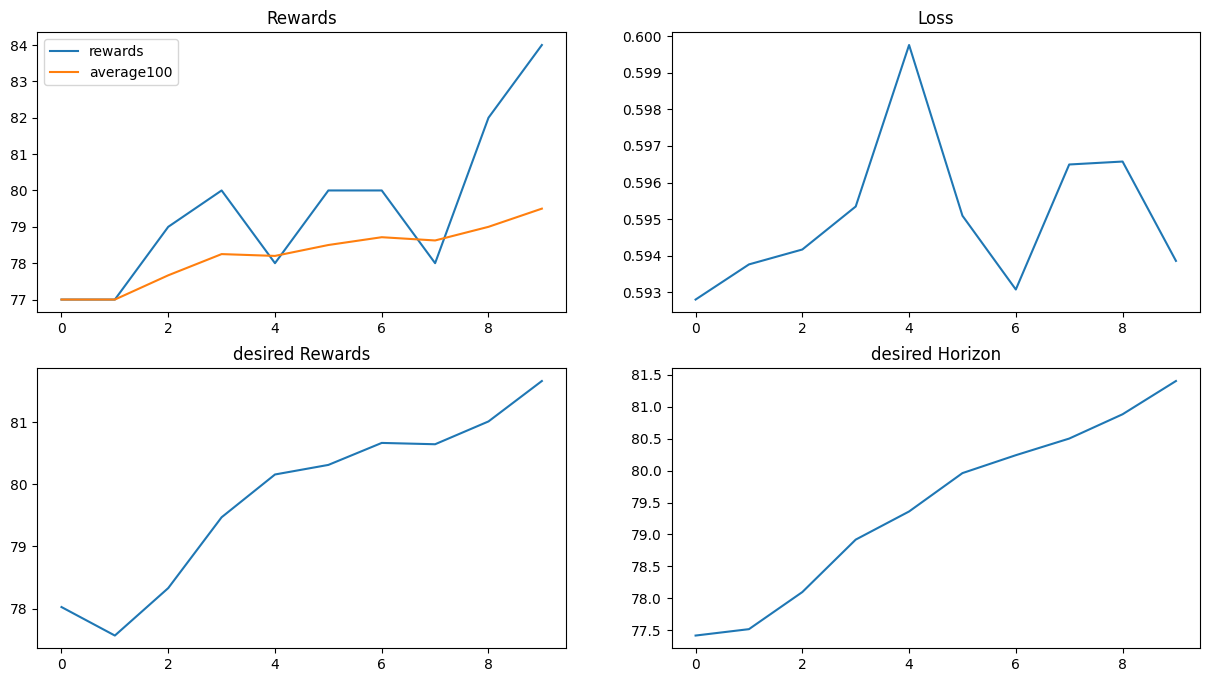

<Figure size 640x480 with 0 Axes>

In [ ]:
# %%time
import os

max_episode = 200
name = "model.pth"

if os.path.exists(name):
    bf.load_state_dict(torch.load(name, weights_only=True))
else:
    rewards, average, d, h, loss = run_upside_down(max_episodes=max_episode)

    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    plt.title("Rewards")
    plt.plot(rewards, label="rewards")
    plt.plot(average, label="average100")
    plt.legend()
    plt.subplot(2,2,2)
    plt.title("Loss")
    plt.plot(loss)
    plt.subplot(2,2,3)
    plt.title("desired Rewards")
    plt.plot(d)
    plt.subplot(2,2,4)
    plt.title("desired Horizon")
    plt.plot(h)
    plt.show()

    plt.savefig(f"imgs/UDRL/cartpole_{max_episode}.png")

    # SAVE MODEL
    name = "model.pth"
    torch.save(bf.state_dict(), name)

In [ ]:
print(average)

In [ ]:
## OBSERVE THE WEIGHTS after training
# for p in bf.parameters():
#    print(p)

## EVALUATION RUN

In [19]:
DESIRED_REWARD = torch.FloatTensor([max_episode]).to(device)
DESIRED_HORIZON = torch.FloatTensor([max_episode]).to(device)
desired = DESIRED_REWARD.item()

# `env` is defined earlier before training
# env = gym.make("CartPole-v0")
env.reset()
rewards = 0
while True:
    command = torch.cat(
        (DESIRED_REWARD * return_scale, DESIRED_HORIZON * horizon_scale), dim=-1
    )

    print(command)

    probs_logits = bf(torch.from_numpy(state).float().to(device), command)
    probs = torch.softmax(probs_logits, dim=-1).detach().cpu()
    action = torch.argmax(probs).item()
    # state, reward, done, info = env.step(action)
    state, reward, done, info, _ = env.step(action)
    rewards += reward
    DESIRED_REWARD -= reward
    DESIRED_HORIZON -= 1
    if done:
        break

print(
    "Desired rewards: {} | after finishing one episode the agent received {} rewards".format(
        desired, rewards
    )
)
env.close()

tensor([0.2000, 0.2000])
tensor([0.1800, 0.1800])
tensor([0.1600, 0.1600])
tensor([0.1400, 0.1400])
tensor([0.1200, 0.1200])
tensor([0.1000, 0.1000])
tensor([0.0800, 0.0800])
tensor([0.0600, 0.0600])
tensor([0.0400, 0.0400])
tensor([0.0200, 0.0200])
tensor([0., 0.])
Desired rewards: 10.0 | after finishing one episode the agent received 11.0 rewards
